In [108]:
# Importing important libraries
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import json
import joblib

In [46]:
# Loading data in json format

def load_data(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data
data=load_data('MentalhealthcareData.json')

In [4]:
# !pip install spacy
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
nlp = spacy.load('en_core_web_md')

In [47]:
# Tokenize and lemmantize
def advanced_preprocess_text(text):
    doc = nlp(text.lower())
    cleaned_text = []
    skip_next = False
    for token in doc:
        if skip_next:
            skip_next = False
            continue
        if token.text == 'not' and token.i + 1 < len(doc):
            cleaned_text.append(token.text + '_' + doc[token.i + 1].lemma_)
            skip_next = True
        elif not token.is_stop and not token.is_punct and token.lemma_ != "-PRON-":
            if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']:
                cleaned_text.append(token.lemma_)
    return " ".join(cleaned_text)

# Example use:
text_example = "I am not feeling well Today."
processed_text = advanced_preprocess_text(text_example)
print(processed_text)


not_feel today


In [48]:
# Preprocess patterns in intents
for intent in data['intents']:
  intent['processed_pattern']   = advanced_preprocess_text(intent['pattern'])

In [8]:
for intent in data['intents'][:5]:
    original_text = intent['pattern']
    preprocessed_text =  intent['processed_pattern']
    print(f"Original: {original_text}\nPreprocessed: {preprocessed_text}\n")

Original: How do I navigate cultural differences with my partner's family?
Preprocessed: navigate cultural difference partner family

Original: What should I do if my partner and I have different levels of emotional intelligence?
Preprocessed: partner different level emotional intelligence

Original: How can I support my partner through a career transition?
Preprocessed: support partner career transition

Original: What should I do if my partner and I have different parenting styles?
Preprocessed: partner different parenting style

Original: How do I handle disagreements about money with my partner?
Preprocessed: handle disagreement money partner



In [9]:
#Convert JSON data into Dataframe
df = pd.json_normalize(data['intents'])




# Exploratory data analytics (eda)

In [10]:
df.head()

,tag,pattern,response,processed_pattern
0,relationship,How do I navigate cultural differences with my...,Navigating cultural differences with your part...,navigate cultural difference partner family
1,relationship,What should I do if my partner and I have diff...,Differences in emotional intelligence can impa...,partner different level emotional intelligence
2,relationship,How can I support my partner through a career ...,Supporting your partner through a career trans...,support partner career transition
3,relationship,What should I do if my partner and I have diff...,Differences in parenting styles can lead to co...,partner different parenting style
4,relationship,How do I handle disagreements about money with...,Disagreements about money are common in relati...,handle disagreement money partner


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tag                877 non-null    object
 1   pattern            877 non-null    object
 2   response           877 non-null    object
 3   processed_pattern  877 non-null    object
dtypes: object(4)
memory usage: 27.5+ KB


In [12]:
df.describe()


,tag,pattern,response,processed_pattern
count,877,877,877,877
unique,312,808,826,763
top,anxiety,What is postpartum psychosis?,No problem! Happy to assist.,
freq,49,4,3,26


In [13]:
# Unique pattern
patterns = df['processed_pattern']
print("Number of unique patterns:", len(patterns.unique()))

Number of unique patterns: 763


In [14]:
# Response Exploration
responses = df['response']
sample_responses = responses.sample(5)
print("Sample Responses:")
for i, response in enumerate(sample_responses):
    print(f"{i+1}. {response}")

Sample Responses:
1. Symptoms of Seasonal Affective Disorder (SAD) may include persistent feelings of sadness, hopelessness, or irritability; loss of interest in activities once enjoyed; changes in appetite or weight; difficulty sleeping or oversleeping; and difficulty concentrating.
2. Depersonalization/derealization disorder is characterized by recurrent episodes of feeling detached from one's body (depersonalization) or surroundings (derealization). Individuals may feel like they are observing themselves from outside their body or that the world is unreal or distorted.
3. Individuals can build resilience through various strategies such as developing strong social connections, practicing self-care, maintaining optimism, seeking support from others, reframing adversity as a learning experience, and nurturing a sense of purpose and meaning in life. Building resilience enhances mental health by promoting adaptive coping, emotional strength, and psychological well-being in the face of ch

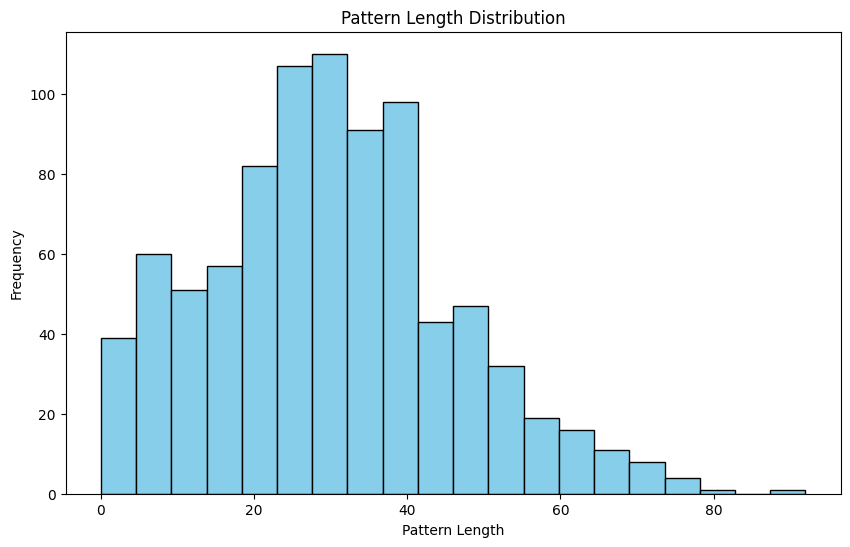

In [49]:
# Data Visualization for Pattern length
plt.figure(figsize=(10, 6))
plt.hist(patterns.apply(len), bins=20, color='skyblue', edgecolor='black')
plt.title('Pattern Length Distribution')
plt.xlabel('Pattern Length')
plt.ylabel('Frequency')
plt.show()


<ipython-input-51-ca427aca0aeb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')


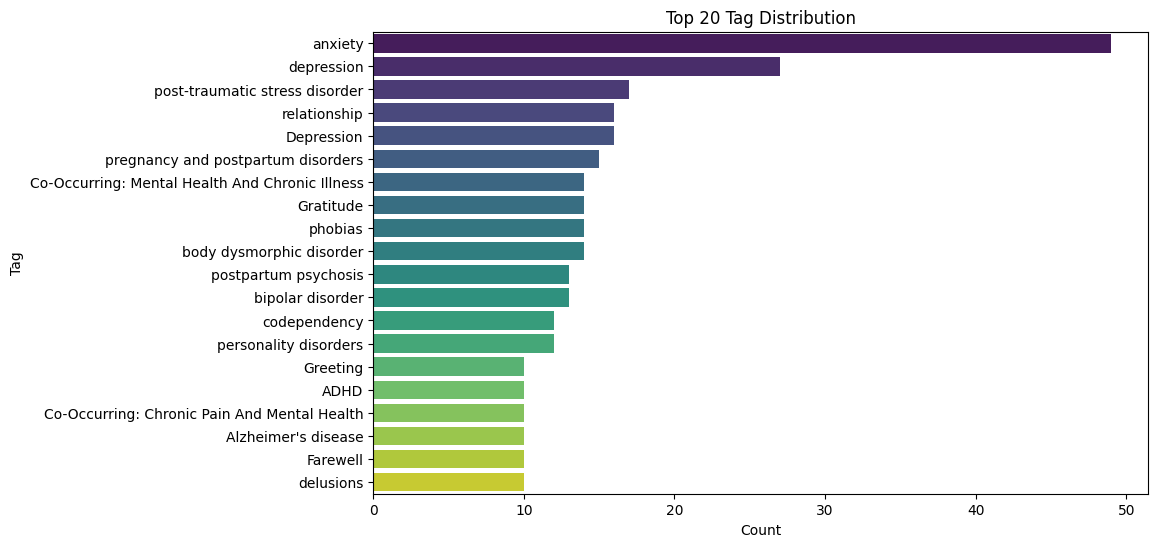

In [51]:
# Tag Graph
top_n = 20
tag_counts = df['tag'].value_counts()
top_tags = tag_counts.nlargest(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title(f'Top {top_n} Tag Distribution')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()


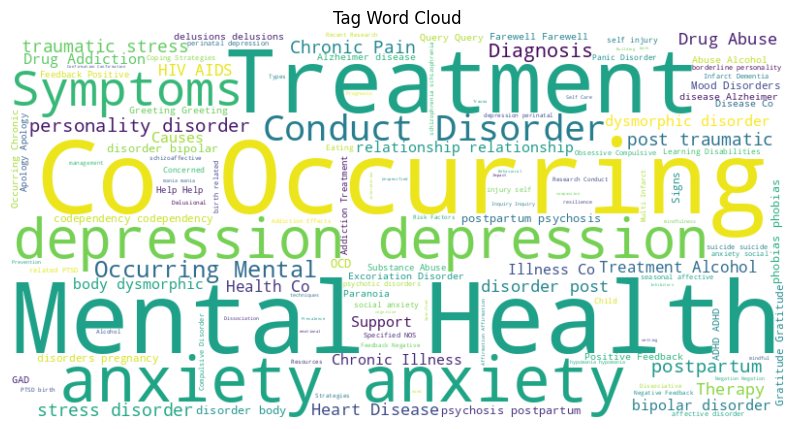

In [17]:
tags_text = ' '.join(df['tag'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Tag Word Cloud')
plt.axis('off')
plt.show()

# Model Training

In [79]:
# Define the augment_data function Bcz data is limited
def augment_data(df, multiplier=5):
    augmented_data = pd.concat([df] * multiplier, ignore_index=True)
    return augmented_data

**Logistic Regression**

In [80]:

def train_and_evaluate_lr(data_file):

    augmented_df = augment_data(data_file)
    # Split the Data
    X_train, X_test, y_train, y_test = train_test_split(augmented_df['processed_pattern'], augmented_df['response'], test_size=0.3, random_state=42)
    start_time = time.time()
    # Define a pipeline with TF-IDF Vectorizer and Logistic Regression Classifier (a simpler model)
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])


    # Train the pipeline
    pipeline.fit(X_train, y_train)

    end_time = time.time()

    time_lr = end_time - start_time
    # Prediction on test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_lr


In [81]:

def predict_input_lr(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response

trained_pipeline_lr, accuracy_lr, time_lr= train_and_evaluate_lr(df)
print("Accuracy:", accuracy_lr)
print("Computation Time:",time_lr)


Accuracy: 0.6649778340721976
Computation Time: 9.789996862411499


**Support Vector Machine**

In [115]:
def train_and_evaluate_svm(data_file):
    augmented_df = augment_data(data_file)

    X_train, X_test, y_train, y_test = train_test_split(augmented_df['processed_pattern'], augmented_df['response'], test_size=0.3, random_state=42)

    # Define a pipeline with TF-IDF Vectorizer and SVM Classifier
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
        ('classifier', SVC(kernel='rbf', C=1.0))  # SVM Classifier with a non-linear kernel
    ])
    start_time = time.time()
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    end_time = time.time()

    time_svm = end_time - start_time
    # Predict on test data
    y_pred = pipeline.predict(X_test)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return pipeline, accuracy, time_svm, precision, recall, f1




In [116]:
def predict_input_svm(pipeline, user_input):
    predicted_response = pipeline.predict([user_input])[0]
    return predicted_response


trained_pipeline_svm, accuracy_svm , time_svm,precision, recall, f1 = train_and_evaluate_svm(df)
print("Accuracy:", accuracy_svm)
print("Computation Time:",time_svm)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)




Accuracy: 0.871580547112462
Computation Time: 1.040215015411377
Precision: 0.8508393405157313
Recall: 0.871580547112462
F1-score: 0.8547160927556063


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Decision Tree**

In [84]:

# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)


# Define a pipeline with TF-IDF Vectorizer and Decision Tree Classifier
pipeline_DTree = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', DecisionTreeClassifier(random_state=42)) ])
start_time = time.time()
# Train the pipeline
pipeline_DTree.fit(X_train, y_train)
end_time = time.time()
time_dt = end_time - start_time
# Predict on test data
y_pred = pipeline_DTree.predict(X_test)



In [85]:
# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_dt)
print("Computation Time:",time_dt)

# Function to predict response
def predict_input_dt(model,user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response


Accuracy: 0.9399696048632219
Computation Time: 5.193119049072266


**Random forest classifier**

In [86]:
# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Define a pipeline with TF-IDF Vectorizer and Random Forest Classifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', RandomForestClassifier())  # Random Forest Classifier
])

start_time = time.time()
# Train the pipeline
pipeline_rf.fit(X_train, y_train)
end_time = time.time()
time_rf = end_time - start_time
# Predict on test data
y_pred = pipeline_rf.predict(X_test)



In [109]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9399696048632219
Precision: 0.9259890481015101
Recall: 0.9399696048632219
F1-score: 0.929724733220174


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:


# Calculate accuracy for Random Forest Classifier
accuracy_rf = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", accuracy_rf)
print("Computation Time:",time_rf)

Random Forest Classifier Accuracy: 0.9399696048632219
Computation Time: 9.930186986923218


In [89]:
def predict_input_rf(model, user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response

**KNN model**

In [112]:
# Data Augmentation
augmented_df = augment_data(df)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(augmented_df['pattern'], augmented_df['response'], test_size=0.3, random_state=42)

# Define a pipeline with TF-IDF Vectorizer and KNN Classifier
pipeline_KNN = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),  # Using bi-grams
    ('classifier', KNeighborsClassifier())  # KNN Classifier
])
start_time = time.time()
# Train the pipeline
pipeline_KNN.fit(X_train, y_train)
end_time = time.time()
time_knn = end_time - start_time
y_pred_knn = pipeline_KNN.predict(X_test)



In [111]:


# Calculate accuracy for KNN Classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)
print("Computation Time:",time_knn)

KNN Classifier Accuracy: 0.6854103343465046
Computation Time: 0.04302835464477539


In [92]:
def predict_input_knn(model, user_input):
    predicted_response = model.predict([user_input])[0]
    return predicted_response

# Accurancy graph

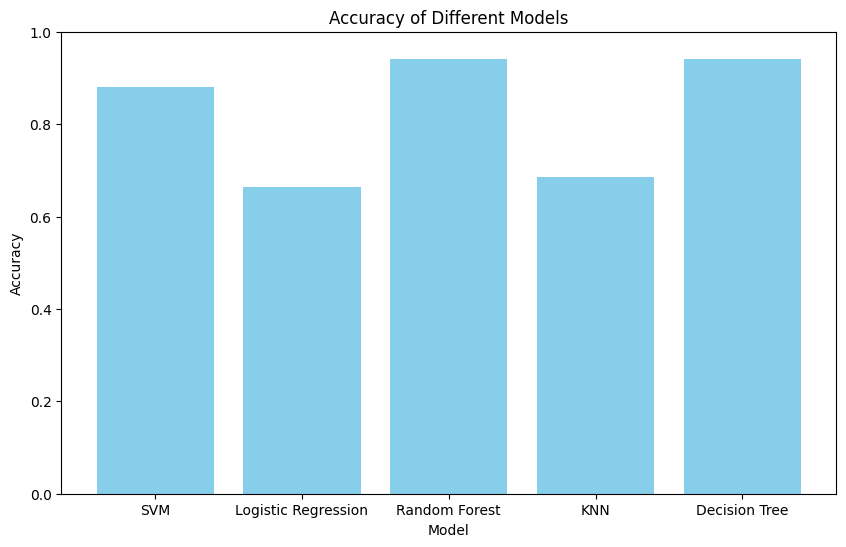

In [114]:
#  model names
models = ['SVM', 'Logistic Regression', 'Random Forest', 'KNN', 'Decision Tree']

# Accuracy for each model
accuracies = [accuracy_svm, accuracy_lr, accuracy_rf, accuracy_knn, accuracy_dt]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.0, 1.0)  # y-axis limit from 0 to 1
plt.show()

# Computation graph

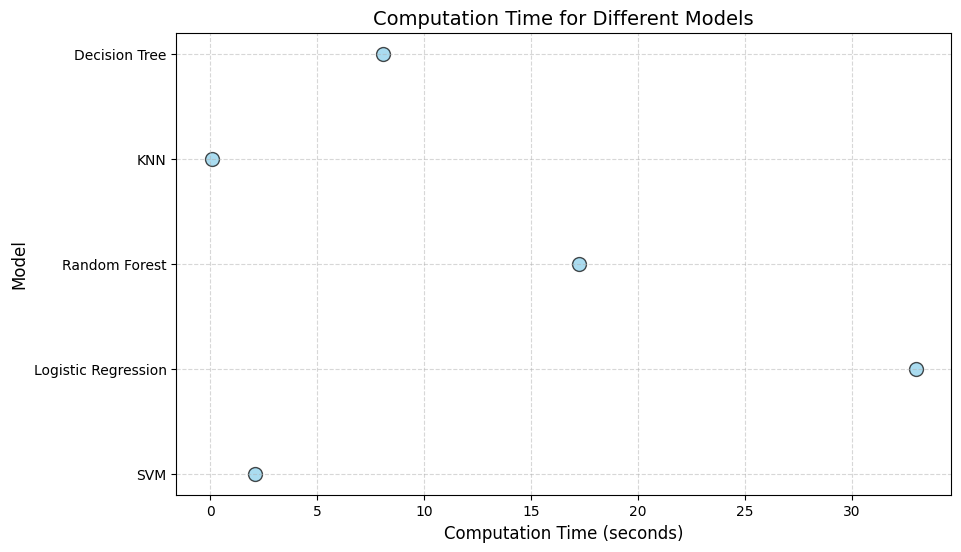

In [ ]:
# List of computation times for each model (replace with actual times)
computation_times = [time_svm, time_lr, time_rf, time_knn, time_dt]
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6))
plt.scatter(computation_times, models, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Computation Time for Different Models', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

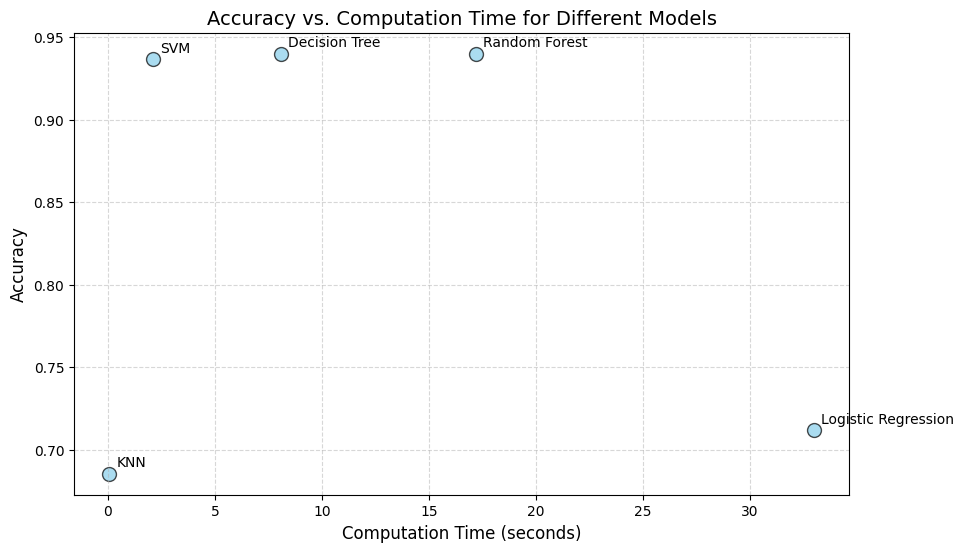

In [ ]:
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6))
plt.scatter(computation_times, accuracies, color='skyblue', edgecolor='black', s=100, alpha=0.7)
plt.xlabel('Computation Time (seconds)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs. Computation Time for Different Models', fontsize=14)
for model, time, accuracy in zip(models, computation_times, accuracies):
    plt.annotate(model, (time, accuracy), xytext=(5, 5), textcoords='offset points', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [119]:
def chatbot():
    print("Chatbot: Hello! I'm your mental health care assistant. Let's talk about how you're feeling today.")
    user_name = input("Chatbot: Before we begin, may I know your name please? ")
    print(f"Chatbot: Nice to meet you, {user_name}! How can I assist you today? Type 'exit' to end our conversation.")

    while True:
       # input
       user_input = input(f"{user_name}: ")
       #  Exit the conversation
       if user_input.lower() in ['exit', 'quit']:
           print(f"Chatbot: Thank you for talking with me, {user_name}. Take care!")
           break
       response_rf = predict_input_rf(pipeline_rf, user_input)
       print("Chatbot: Random Forest:", response_rf)



In [120]:
# Call the chatbot
chatbot()

Chatbot: Hello! I'm your mental health care assistant. Let's talk about how you're feeling today.
Chatbot: Before we begin, may I know your name please? saab
Chatbot: Nice to meet you, saab! How can I assist you today? Type 'exit' to end our conversation.
saab: my doctor said i have anxiety so what is anxiety
Chatbot: Random Forest: Anxiety is a normal and often necessary response to stress or danger. It is characterized by feelings of worry, nervousness, or fear that are disproportionate to the actual threat. While occasional anxiety is a natural part of life, excessive or persistent anxiety that interferes with daily functioning may indicate an anxiety disorder.
saab: how to treat this anxiety
Chatbot: Random Forest: Medications such as selective serotonin reuptake inhibitors (SSRIs) are sometimes prescribed to help manage symptoms of Excoriation Disorder, particularly if anxiety or obsessive-compulsive symptoms are present. SSRIs work by increasing levels of serotonin in the brain, 

In [96]:

# Save model
joblib.dump(trained_pipeline_svm, 'svm_model.joblib')

joblib.dump(pipeline_rf, 'Random_forest_model.joblib')



['Random_forest_model.joblib']

In [ ]:
# from google.colab import files
# files.download('svm_model.joblib')

In [ ]:
pip freeze


In [ ]:
# pip freeze > 'requirements.txt'